In [44]:

#by Henry Schumacher
#-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-#
import os
import sys
import json
import uuid
import xraydb
#-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-#
import numpy as np
import pandas as pd
import pyxray as xy
import seaborn as sb
#-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-#
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
#-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-#
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times"],
    "text.usetex": True,
    "font.size": 8,
    "pgf.rcfonts": False
})
# rc('font',**{'family':'serif','serif':['Times']})
# rc('text', usetex=True)
# plt.rcParams.update({'font.size': 8})

plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "pgf.preamble": "\n".join([
          r"\usepackage{mathtools}",
     ]),
})
#-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-#
from json_to_np import *
from colors import load_colors
#-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-#


mac = hex(uuid.getnode())
print(f"MAC address: {mac}")

mac_dict = {'0xb6ab0b4445f9': ['C://Users//schum//Documents//Filing Cabinet//1_RootFilesGeant4', 'C://Users//schum//Documents//Filing Cabinet//2_jsonFiles'], # Office
            '0x145afc4fe836': ['C://Users//schum//Documents//root_files_temp_storage', 'C://Users//schum//Documents//json_files_temp_storage'], # Laptop
            '0x1a7dda7115'  : ['B://IBA//root', 'B://IBA//json']} # Home PC
# Each mac adresse leads to a pair of paths, the first being the folder, 
# where the root files are, the second, where the json files are supposed to be stored
# root_path = mac_dict[mac][0]
json_path = mac_dict[mac][1]

color_schemes = load_colors()
# print(color_schemes)

MAC address: 0xb6ab0b4445f9


In [ ]:
def peak_text_prompter(peaks, counts, bin_edges, delta_bin):
    '''
    Energies from this function are in keV! \n
    '''
    energy_bins = {}
    for p in peaks:
        energy_bins[p] = [bin_edges[p], bin_edges[p] + delta_bin/2, bin_edges[p+1]]
    # print(energy_bins)
    return True

#print(t[2].ljust(30) + '| ' + t[5].ljust(20) + '| ' + t[4].ljust(32) + '| ' + longstop.ljust(32) + '| ' + t[0].ljust(10) + '| ' + ''.ljust(10) + '| ' + '\n' + '--'.ljust(145,'-'))

In [57]:
def array_to_histo(data, mask_max = 10):
    '''
    data = numpy array \n
    mask_max = float; in keV
    '''
    B = int(mask_max/0.12)
    counts, bin_edges = np.histogram(data[data <= mask_max], bins=B)
    delta_bin = abs(bin_edges[0] - bin_edges[1])

    # print("Counts:", counts)
    # print("Bin edges:", bin_edges)
    peaks, properties = find_peaks(counts, height=0)
    # print(peaks)
    peak_text_prompter(peaks, counts, bin_edges, delta_bin)
    plt.figure(figsize=(6,4), dpi=250)
    plt.hist(data[data <= mask_max], bins=B, color="#C6C6C6", edgecolor='#C6C6C6', zorder=2)
    # plt.hist(data[data <= mask_max][peaks], bins=B, color='firebrick', edgecolor='firebrick', zorder=2) BAR PLOT?
    plt.plot(bin_edges[peaks]+ delta_bin/2, counts[peaks], 'bx', label='Prominent Peaks')
    plt.xlabel('Ekin')
    plt.ylabel('Counts')
    plt.yscale('linear')
    # plt.ylim(0,500)
    # plt.xlim(8,10)
    plt.legend()
    plt.title("Histogramm von Ekin")
    plt.grid(True, zorder=1, alpha=0.25)
    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example data
data = np.random.randn(1000)

# Compute histogram (without plotting)
counts, bin_edges = np.histogram(data, bins=20)

# Choose bin indices you want to keep
bins_to_keep = [3, 5, 6, 10]  # example bin indices

# Filter counts and bin centers for the chosen bins
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
selected_counts = counts[bins_to_keep]
selected_centers = bin_centers[bins_to_keep]
selected_widths = np.diff(bin_edges)[bins_to_keep]

# Plot only selected bins as a bar chart
plt.bar(selected_centers, selected_counts, width=selected_widths, edgecolor='black', alpha=0.7)
plt.title("Selected Histogram Bins")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [23]:
def nD_histogram(data, nD):
    if (type(data) != dict):
        pass #ARRAY
    else:
        df = pd.DataFrame({
            'theta': data['theta'],
            'phi': data['phi']
        })
        plt.figure(figsize=(6,4), dpi=250)
        sb.histplot(data=df, x='theta', y='phi', bins=50, cbar=True, cmap='viridis')
        # Customize labels and title
        plt.title("2D Heatmap of Spherical Angles theta and phi")
        plt.xlabel("theta (radians)")
        plt.ylabel("phi (radians)")

        # Show plot
        plt.tight_layout()
        plt.show()
    return 42

In [ ]:
def full_histo_suite(data):
    

In [5]:
data = json_to_np(json_path + "//BonnPIXE2_Blade15_Front17544_PIXE_1.json" , json_field='all')

nD_histogram(data,nD=2)


True
Array for key Ekin created. 1/3
Array for key theta created. 2/3
Array for key phi created. 3/3


NameError: name 'nD_histogram' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde

# Convert to Cartesian coordinates (unit sphere)
x = np.sin(data['theta']) * np.cos(data['phi'])
y = np.sin(data['theta']) * np.sin(data['phi'])
z = np.cos(data['theta'])

# Estimate density in θ–φ space
values = np.vstack([data['theta'], data['phi']])
density = gaussian_kde(values)(values)  # density evaluated at each (θ, φ)

# Plotting
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each point with color based on density
sc = ax.scatter(x, y, z, c=density, cmap='plasma', s=1, alpha=0.8)

# Optional: wireframe for reference
u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:20j]
xs = np.sin(v) * np.cos(u)
ys = np.sin(v) * np.sin(u)
zs = np.cos(v)
ax.plot_wireframe(xs, ys, zs, color='gray', linewidth=0.2, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(sc, ax=ax, shrink=0.6)
cbar.set_label("Point Density in θ–φ Space")

# Clean look
ax.set_title('Sphere Colored by Angular Density')
ax.set_box_aspect([1,1,1])
ax.axis('off')

plt.tight_layout()
plt.show()


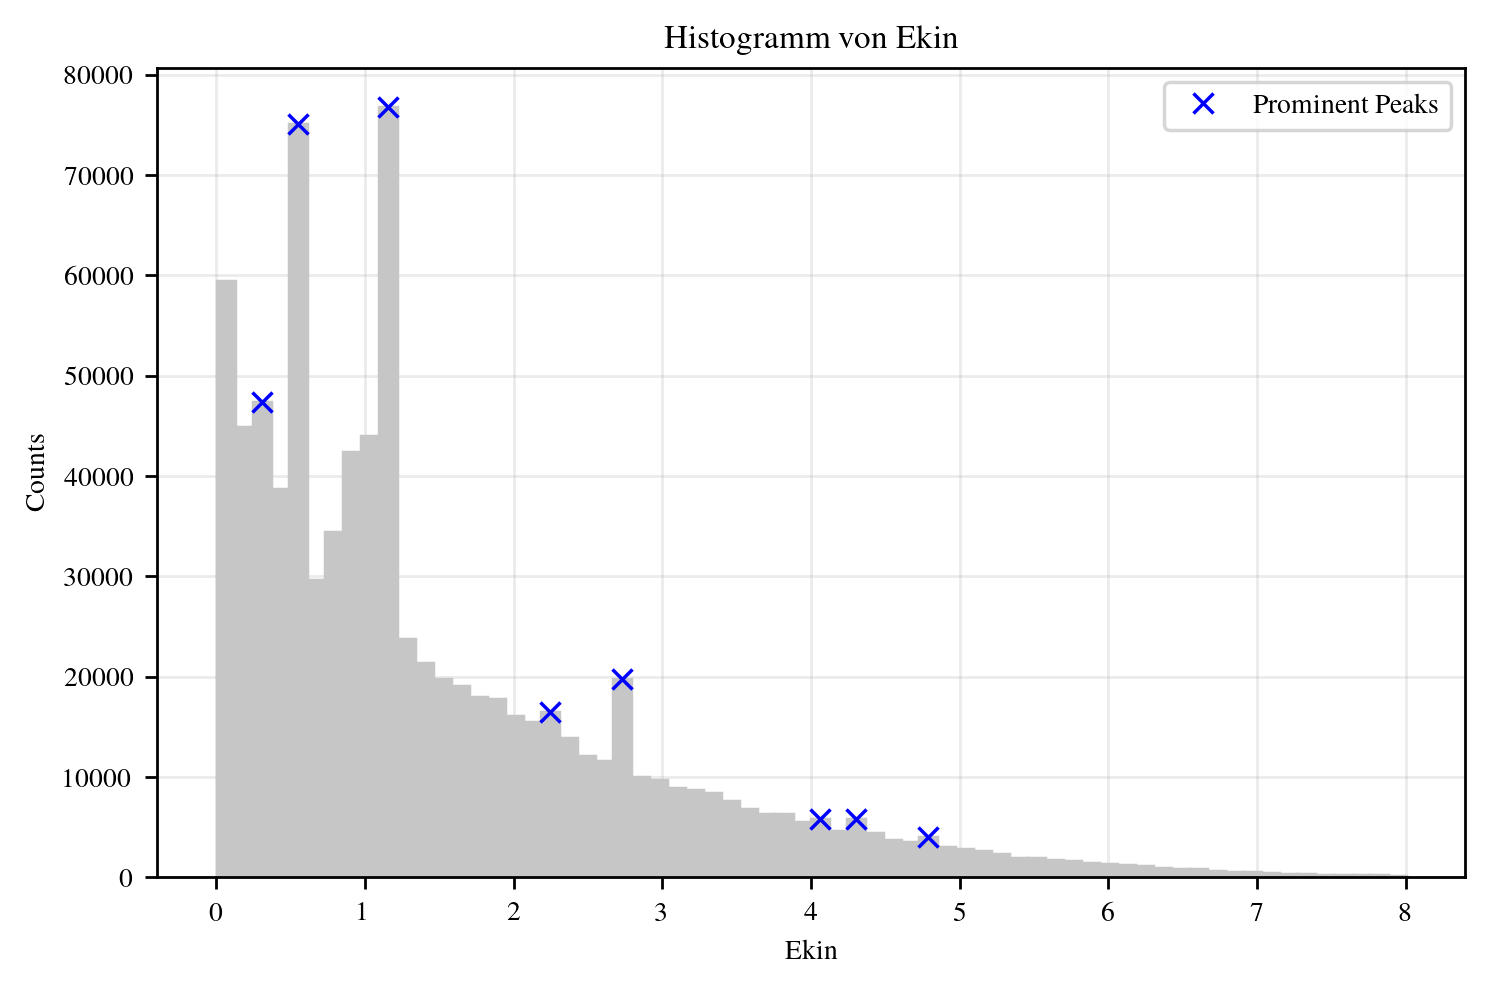

In [58]:
array_to_histo(data['Ekin'], mask_max=8)

In [ ]:
xy.xray_transition_energy_eV(25, 'La1')

637.0